In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE, plot_ale

import shap
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pylab as pl


plt.rcParams.update({'font.size': 18})

# print the JS visualization code to the notebook
shap.initjs()

Import the shear wall database

In [2]:
data1 = pd.read_excel('Shear_Wall_Strength_Database.xlsx', sheet_name='NewDatabase')
data1.head()

,Unnamed: 0,Author,Specimen,Number,Number.1,M/Vlw,lw/tw,"ρvwFy,vw/fc","ρhwFy,hw/fc","ρvcFy,vc/fc","ρhcFy,hc/fc",P/fcAg,Ab/Ag,fc,τmax
0,1,Lefas et al. (1990a),SW11,1,197,1.000000,8.333333,0.050515,0.026268,0.954181,0.026268,0.000000,0.000000,19.400,1.650000
1,2,Lefas et al. (1990a),SW12,2,234,0.559688,24.880597,0.157426,0.179372,0.799852,0.195462,0.195703,0.000000,18.300,5.257456
2,3,Lefas et al. (1990a),SW13,3,244,2.200000,8.000000,0.086551,0.092531,0.322530,0.144580,0.216293,0.000000,18.216,1.909472
3,4,Lefas et al. (1990a),SW14,4,270,2.100000,10.000000,0.012289,0.032444,0.137836,0.039326,0.136487,0.000000,73.560,3.326000
4,5,Lefas et al. (1990a),SW15,5,137,0.842105,57.000000,0.326964,0.326964,0.541458,0.013994,0.000000,0.307692,31.900,4.016239


In [3]:
len(data1)

391

In [4]:
data=data1.loc[:, 'M/Vlw':'τmax']
data.head()

,M/Vlw,lw/tw,"ρvwFy,vw/fc","ρhwFy,hw/fc","ρvcFy,vc/fc","ρhcFy,hc/fc",P/fcAg,Ab/Ag,fc,τmax
0,1.000000,8.333333,0.050515,0.026268,0.954181,0.026268,0.000000,0.000000,19.400,1.650000
1,0.559688,24.880597,0.157426,0.179372,0.799852,0.195462,0.195703,0.000000,18.300,5.257456
2,2.200000,8.000000,0.086551,0.092531,0.322530,0.144580,0.216293,0.000000,18.216,1.909472
3,2.100000,10.000000,0.012289,0.032444,0.137836,0.039326,0.136487,0.000000,73.560,3.326000
4,0.842105,57.000000,0.326964,0.326964,0.541458,0.013994,0.000000,0.307692,31.900,4.016239


##### Convert the String in Section to numerical values

In [5]:
# Generate X and y data
X = data.loc[:, data.columns != 'τmax']
y=data['τmax']
#X.head()

In [6]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# type(X_train)

In [8]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train1 = scaler.fit_transform(X_train)
# type(X_train1)

In [9]:
# X_train1

In [10]:
# X_train2 = X_train.to_numpy()
# X_train2

In [11]:

import xgboost as xgb
from xgboost import plot_importance
XGB_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
XGB_model.fit(X_train, y_train)

Series.base is deprecated and will be removed in a future version


[21:26:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [12]:
# Print the MSE
mean_squared_error(y_test, XGB_model.predict(X_test))

0.2638795586841556

In [13]:
feature_names = X.columns
print(feature_names)

Index(['M/Vlw', 'lw/tw', 'ρvwFy,vw/fc', 'ρhwFy,hw/fc', 'ρvcFy,vc/fc',
       'ρhcFy,hc/fc', 'P/fcAg', 'Ab/Ag', 'fc'],
      dtype='object')


# XGB Feautre importance

In [14]:
#plt.barh(feature_names, XGB_model.feature_importances_)

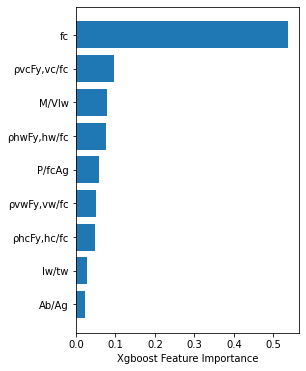

In [15]:
sorted_idx = XGB_model.feature_importances_.argsort()
plt.figure(figsize=(4,6))
plt.barh(feature_names[sorted_idx], XGB_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.savefig('ShearWall_XGBoost_importance.eps',format='eps', dpi=1000)


# ALE

In [16]:
#X_train = X_train.to_numpy()

In [17]:
#X_train

In [18]:
XGB_ale = ALE(XGB_model.predict, feature_names=feature_names, target_names=['τmax'])

In [19]:
XGB_exp = XGB_ale.explain(X_train)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


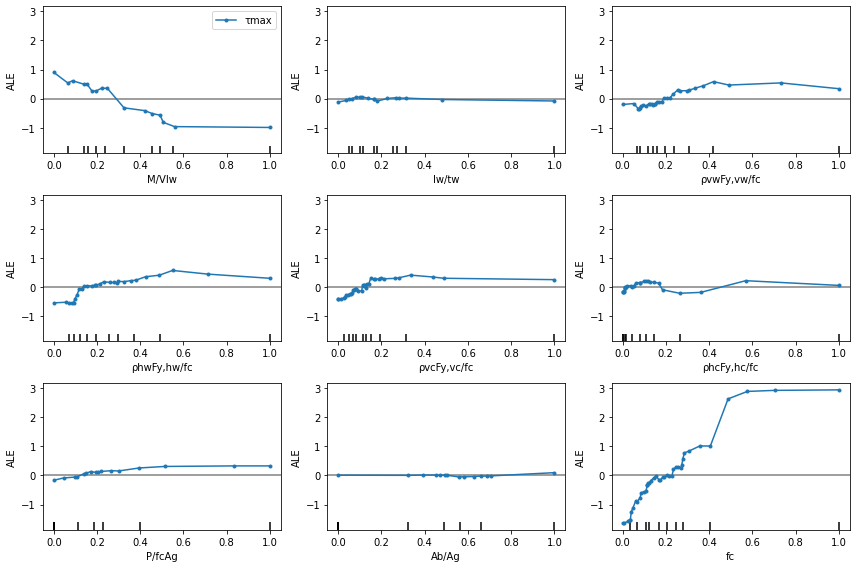

In [20]:
# ALE value is the relative feature effect on the prediction at that feature value.
plot_ale(XGB_exp, n_cols=3, fig_kw={'figwidth':12, 'figheight': 8});
plt.savefig('ShearWall_ALE.eps',format='eps', dpi=1000)

# Partial Dependance Plots

In [21]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [22]:
feature_names

Index(['M/Vlw', 'lw/tw', 'ρvwFy,vw/fc', 'ρhwFy,hw/fc', 'ρvcFy,vc/fc',
       'ρhcFy,hc/fc', 'P/fcAg', 'Ab/Ag', 'fc'],
      dtype='object')

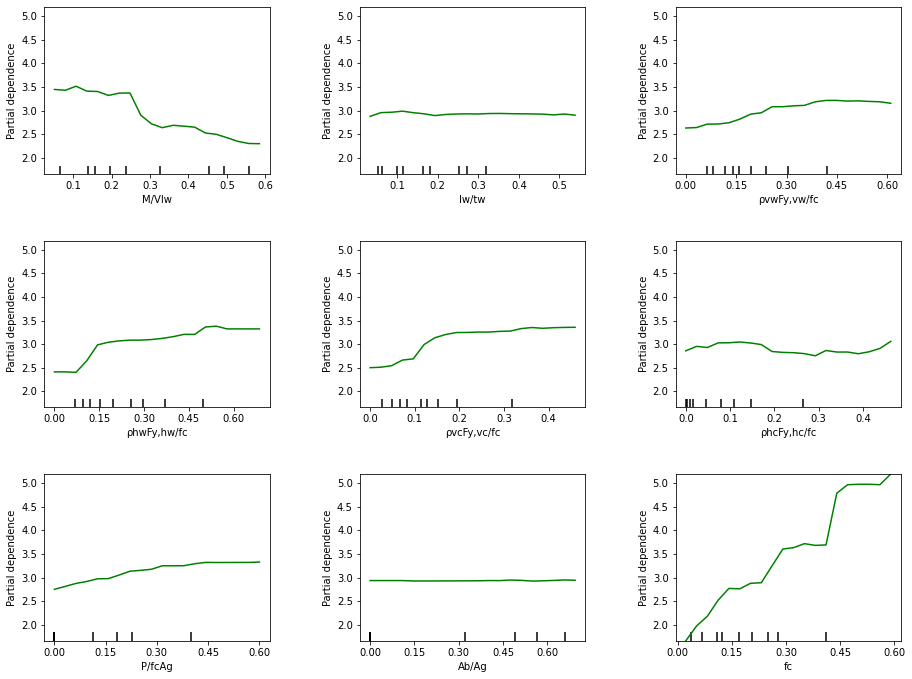

In [23]:

features = [i for i in range(0, len(X.columns))]  # Features used for computing and plotting PDPlot
plot_partial_dependence(XGB_model, X_train, features, feature_names, n_jobs=3, grid_resolution=20)
fig = plt.gcf()

fig.set_size_inches(14, 16)
fig.subplots_adjust(wspace=0.4,hspace=0.4)
plt.savefig('ShearWall_PDP.eps',format='eps', dpi=1000)

# SHAP value

In [24]:
X_shap = scaler.transform(X)
X_shap = pd.DataFrame(X_shap, columns = X.columns)

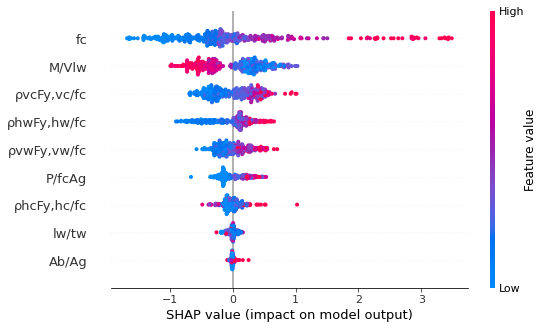

<Figure size 432x288 with 0 Axes>

In [25]:
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap)
plt.savefig('ShearWall_SHAP_summary.eps',format='eps', dpi=1000)

In [26]:
# Single value explainer
shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap.iloc[0,:])

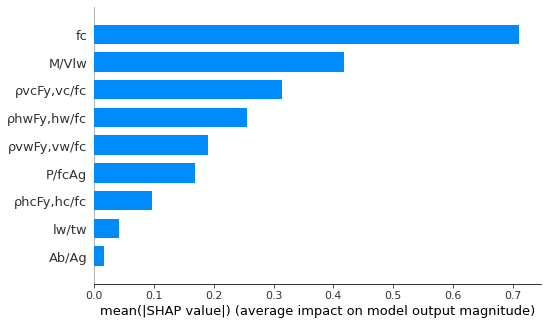

In [27]:
shap.summary_plot(shap_values, X_shap,  plot_type="bar", show=False)
plt.savefig('shear_wall_shap_barplot.eps',format='eps', dpi=1000)

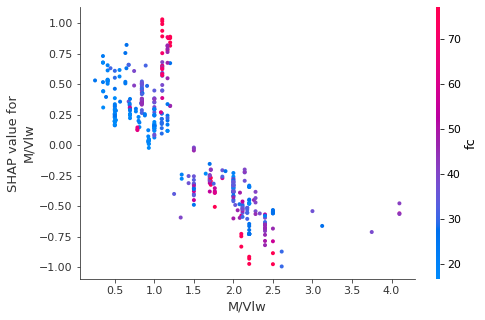

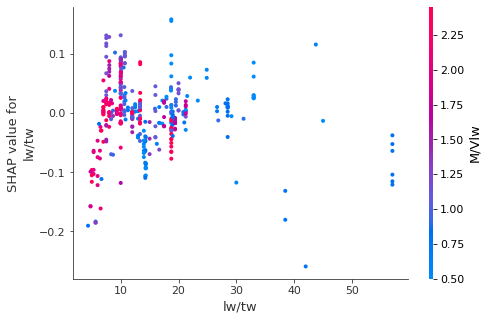

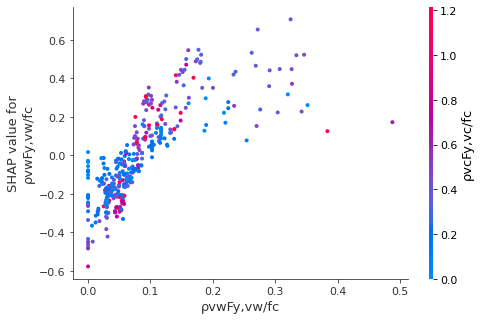

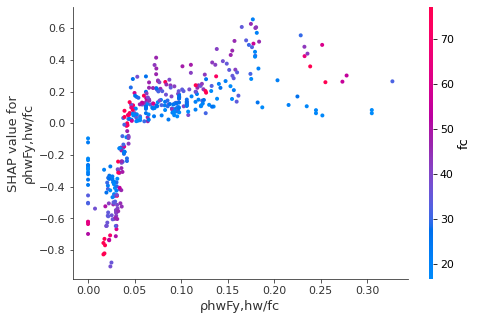

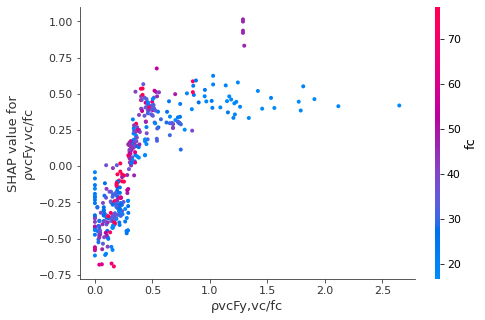

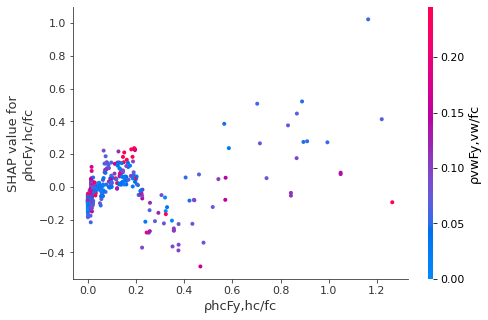

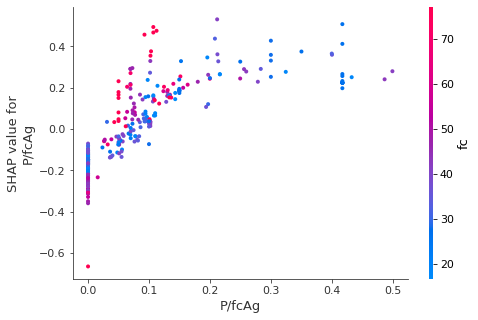

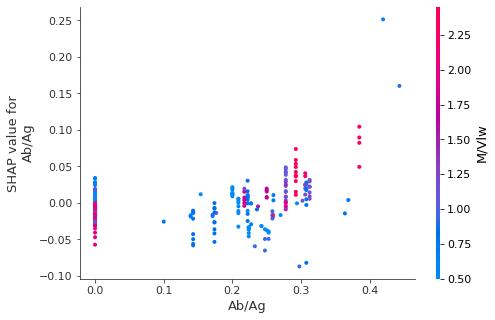

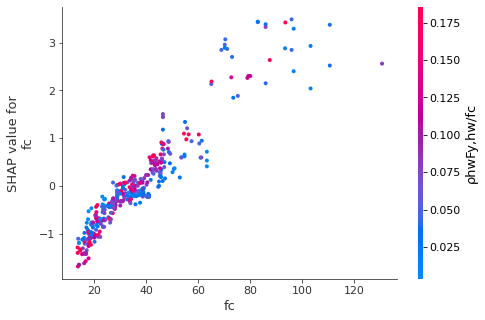

In [28]:
# Plot the dependance plot for class 0
n=1
for name in X_shap.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_shap, show=False )
    
    plt.savefig("Shearwall_dependance_" + str(n) +".eps", format="EPS")
    n=n+1


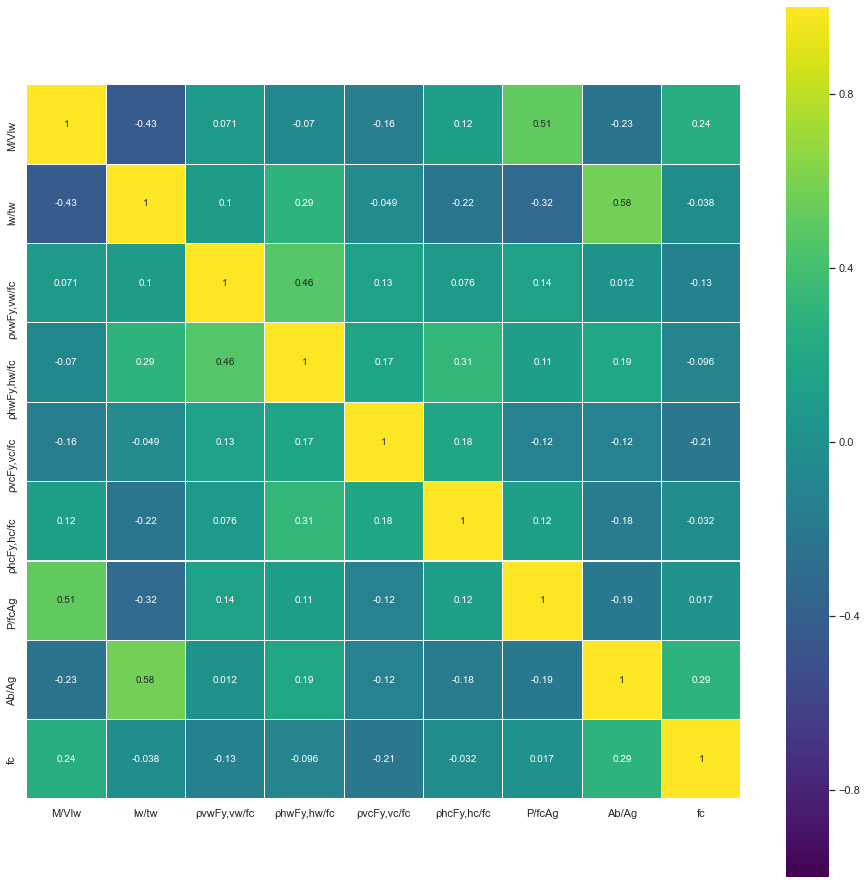

In [29]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

corr = data.drop('τmax', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(16, 16))

sns.heatmap(corr[(corr >= 0.0) | (corr <= -0.0)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);